# Task 5: SLAM

In this notebook, we will test your SLAM implementation using a pre-recorded run of our robot. To see the results of your implementation, we will use the viewer.py with the --local option, which receives messages from a local (simulated) robot instead of the raspberry pi.

**Note:** This notebook doesn't contain any implementation tasks. All implementation parts of this tasks have to be done in *utils/EKFSLAM.py*.

## Imports

In [1]:
# imports
from matplotlib import pyplot as plt
import numpy as np


import sys
import os
# Depending on where you run this notebook, you might have to change this path. It should point to the robot-code folder.
sys.path.insert(1, os.path.join(os.getcwd(), '..'))

import jsonpickle

from utils.EKFSLAM import EKFSLAM
from utils.camera import Camera
from utils.vision import Vision
from utils.recorder import Recorder


from message import Message
from publisher import Publisher
from timeit import default_timer as timer
from types import SimpleNamespace
import imagezmq

## Setup

Setup SLAM, the recorder (used for loaded the pre-recorded robot path), and the publisher that sends messages with the current (loaded) camera image and position of the robot (as computed by your SLAM implementation) to the robot viewer.

In [ ]:
slam = EKFSLAM(
        0.027216,
        0.145,
        MOTOR_STD=4,
        DIST_STD=0.1,
        ANGLE_STD=4
    )
# Note that this is the camera configuration specific to our robot!
camera_config = SimpleNamespace(**{"x_offset": 0.03,
                    "z_offset": 0.28,
                    "y_angle": -2.28, # -130 deg
                    "exposure_time": 60,
                    "gain": 100})

camera = Camera(60, 100)
vision = Vision(camera.CAMERA_MATRIX, camera.DIST_COEFFS, camera_config)
detected_ids = set()

recorder = Recorder(0.1)
publisher = Publisher()

Start the publisher for the data received by the viewer and register it to port 5555. Now the notebook will publish messages with the current camera image, detected landmarks, and estimated robot position, just like the actual robot does. Call *python viewer.py --local* to display the results in the robot viewer.

In [4]:
publisher.sender = imagezmq.ImageSender(connect_to='tcp://*:5555', REQ_REP=False)

Function for running SLAM.

In [5]:
def run_ekf_slam(img, draw_img=None, fastmode=False, l=0, r=0, old_l=0, old_r=0):
        # movements is what is refered to as u = (l, r) in the document
        movements = l - old_l, r - old_r
        if movements[0] != 0.0 or movements[1] != 0:
            slam.predict(*movements)

        arucos, _ = vision.detections(img, draw_img, slam.get_robot_pose())

        ids, landmark_rs, landmark_alphas, landmark_positions = arucos
    
        # add and correct arucos
        if len(ids) > 0:
            for i, id in enumerate(ids):
                if fastmode and i > 4:
                    break
                # actual_measurement is the distance r and angle alpha of the landmark relative to the robot.
                # world_coords are the world coordinates of the landmark.
                # id is a unique number identifying the landmark.

                # if id in self.detected_ids: # measure the id at least 2 times and then add it to slam
                if id not in slam.get_landmark_ids():
                    slam.add_landmark(landmark_positions[i], (landmark_rs[i], landmark_alphas[i]), id)
                    print(f"Landmark with id {id} added,pos:{landmark_positions[i]}, r:{landmark_rs[i]}, a:{landmark_alphas[i]}")
                else:
                    # correct each detected landmark that is already added
                    slam.correction((landmark_rs[i], landmark_alphas[i]), id)

                # self.detected_ids.add(id)

        robot_x, robot_y, robot_theta, robot_stdev = slam.get_robot_pose()
        landmark_estimated_positions, landmark_estimated_stdevs, landmark_estimated_ids = slam.get_landmark_poses()

        data = SimpleNamespace()
        data.landmark_ids = ids
        data.landmark_rs = landmark_rs
        data.landmark_alphas = landmark_alphas
        data.landmark_positions = landmark_positions
        data.landmark_estimated_ids = landmark_estimated_ids
        data.landmark_estimated_positions = landmark_estimated_positions
        data.landmark_estimated_stdevs = landmark_estimated_stdevs

        data.robot_position = np.array([robot_x, robot_y])
        data.robot_theta = robot_theta
        data.robot_stdev = robot_stdev

        return data

Run SLAM using the pre-recorded robot movements.

In [ ]:
# Load the pre-recorded robot movements
recorder.load_recording("./2024-09-12_17-29-34")
count = 0
# last and current rotition of the robot's wheels
old_l = 0
old_r = 0
l = 0
r = 0
running = True
while running:
    try:
        raw_img, speed, turn, x, y, theta, l, r = next(recorder.get_step)
    except StopIteration:
        print("#### REPLAY COMPLETED #####")
        running = False 

    draw_img = raw_img.copy()
    data = run_ekf_slam(raw_img, draw_img, l=l, r=r, old_l=old_l, old_r=old_r)
    old_l = l
    old_r = r

    msg = Message(
                id = count,
                timestamp = timer(),
                start = True,
    
                landmark_ids = data.landmark_ids,
                landmark_rs = data.landmark_rs,
                landmark_alphas = data.landmark_alphas,
                landmark_positions = data.landmark_positions,
    
                landmark_estimated_ids = data.landmark_estimated_ids,
                landmark_estimated_positions = data.landmark_estimated_positions,
                landmark_estimated_stdevs = data.landmark_estimated_stdevs,
    
                robot_position = data.robot_position,
                robot_theta = data.robot_theta,
                robot_stdev = data.robot_stdev,
    
                text = f"cam fps: {0}"
            )

    msg_str = jsonpickle.encode(msg)
    publisher.publish_img(msg_str, draw_img, False)
    count = count + 1

After finishing, we close the publisher, as it would otherwise continue to block port 5555 and make it impossible to register a new publisher (or anything else) to that port.

In [ ]:
# close the publisher and free the port
publisher.close()

Finally, this is roughly what your map should look like in the end

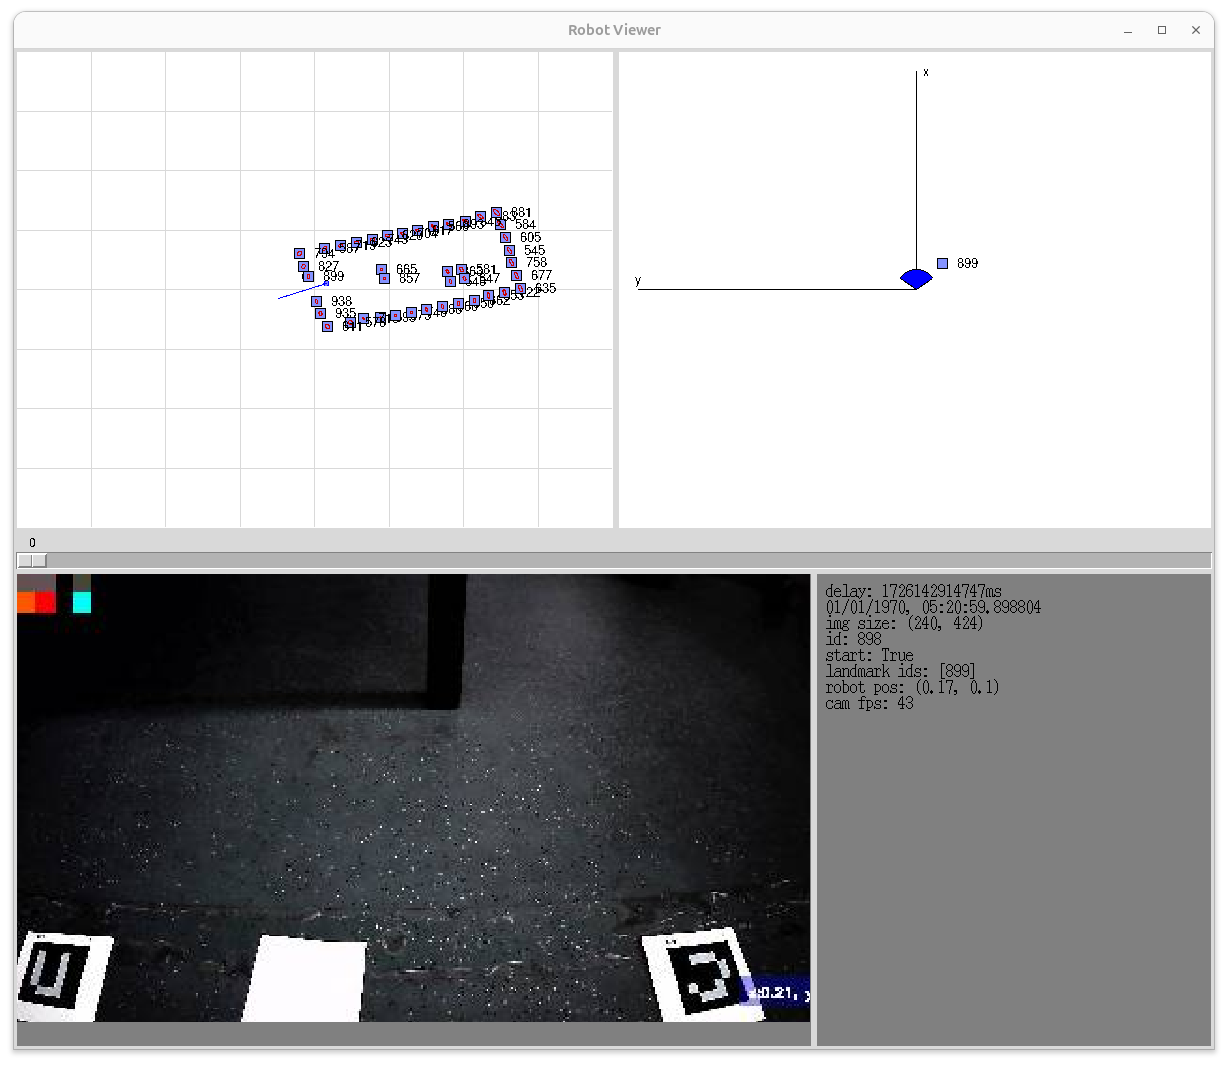